# Data reduction for the hap-hd channel

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord,Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [55]:
#from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel
)
from gammapy.modeling import Fit


import gammapy
gammapy.__version__

'0.18.2'

In [56]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [57]:
from pathlib import Path

path = Path("../../../hess_results/GC_variability_0.18.2/hap-hd")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

patho = Path(path/"offsets")
patho.mkdir(exist_ok=True)

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

## Datastore Creation

In [58]:
data_path = Path("$GAMMAPY_DATA/hap-hd_Prod05")
data_store_hess1 = DataStore.from_dir(data_path / "hess1/std_ImPACT_fullEnclosure")
data_store_hess1u = DataStore.from_dir(data_path / "hess1u/std_ImPACT_fullEnclosure")
data_store_hess2 = DataStore.from_dir(data_path / "hess2/std_ImPACT_fullEnclosure")

## Data selection

In [59]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(1.8, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=[0., 50])

obs_table1 = data_store_hess1.obs_table.select_observations(selection)
obs_table1 = obs_table1.select_observations(selectionZEN)

obs_table1u = data_store_hess1u.obs_table.select_observations(selection)
obs_table1u = obs_table1u.select_observations(selectionZEN)

obs_table2 = data_store_hess2.obs_table.select_observations(selection)
obs_table2 = obs_table2.select_observations(selectionZEN)

In [60]:
#HESS1
ids = obs_table1["OBS_ID"] 
observations1 = data_store_hess1.get_observations(ids, skip_missing=True)

#HESS1U
ids = obs_table1u["OBS_ID"]
observations1u = data_store_hess1u.get_observations(ids, skip_missing=True)

# HESS2
ids = obs_table2["OBS_ID"]
observations2 = data_store_hess2.get_observations(ids, skip_missing=True)

In [11]:
# Removing observations lacking IRFs (effective area, energy dispersion, point spread function and background model)
# peut être pas besoin ici

#HESS1
ids = obs_table1["OBS_ID"]
observations1 = data_store_hess1.get_observations(ids, skip_missing=True)

for obs in observations1:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations1 = data_store_hess1.get_observations(ids, skip_missing=True)
obs_table1 = obs_table1.select_obs_id(ids)


#HESS1U
ids = obs_table1u["OBS_ID"]
observations1u = data_store_hess1u.get_observations(ids, skip_missing=True)

for obs in observations1u:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations1u = data_store_hess1u.get_observations(ids, skip_missing=True)
obs_table1u = obs_table1u.select_obs_id(ids)


# HESS2
ids = obs_table2["OBS_ID"].tolist()
observations2 = data_store_hess2.get_observations(ids, skip_missing=True)

for obs in observations2:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations2 = data_store_hess2.get_observations(ids, skip_missing=True)
obs_table2 = obs_table2.select_obs_id(ids)

In [77]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

## Creating the geometry for the dataset

In [14]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, 20, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_energy_bounds(
    0.3, 200, 30, unit="TeV", name="energy_true"
)

In [64]:
# Creating the MapDataset objects

stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="stacked")


stacked_period = Datasets([MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="hess1"),
                           MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="hess1u"),
                           MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="hess2")])

datasets_year = Datasets()

for k in range (2004,2020):
    name = f"map_{k}"
    datasets_year.append(MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name=name))

In [16]:
exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

In [17]:
offset_max = 1.8 * u.deg

maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak"], offset_max=offset_max)
maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)

In [18]:
#histo_thresh = dict()
#for k in range(2004,2020): histo_thresh[k] = []
#histo_thresh_tot = []
#histo_thresh1 = []
#histo_thresh2 = []
#histo_thresh1u = []

## Datasets (total, for each period, and for each year)

In [65]:
%%time

for obs in observations1:
    #print(f"Processing obs ID: {obs.obs_id}")
    cutout = stacked.cutout(obs.pointing_radec, width=2.0 * offset_max)

    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
        
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
        
    dataset = maker_bkg.run(dataset)
       
    year = dataset.gti.time_start.jyear.astype('int')[0]
    norm_bkg = dataset.background_model.spectral_model.norm.value
    
    if np.abs(norm_bkg - 1.) <= 0.3:
        # The resulting dataset cutout is stacked onto the final one
        datasets_year[f"map_{year}"].stack(dataset)
        stacked.stack(dataset)
        stacked_period["hess1"].stack(dataset)
        
        # Attempting to save the energy threshold (not working)
        #i = 0
        #threshold = np.max(dataset.mask_safe.data[i, :,:])
        
        #while threshold == False:
        #   i+=1
        #    threshold = np.max(dataset.mask_safe.data[0, :,:])
            
        #histo_thresh[year].append(energy_axis.edges[i].value)
        #histo_thresh1.append(energy_axis.edges[i].value)
        #histo_thresh_tot.append(energy_axis.edges[i].value)
  
    #else:
    #    print(f"Bkg norm is out of bounds: {norm_bkg:.2f}. Rejecting observation {obs.obs_id}.")
        
for obs in observations2:
    #print(f"Processing obs ID: {obs.obs_id}")
    cutout = stacked.cutout(obs.pointing_radec, width=2.0 * offset_max)

    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
        
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
        
    dataset = maker_bkg.run(dataset)
       
    year = dataset.gti.time_start.jyear.astype('int')[0]
    norm_bkg = dataset.background_model.spectral_model.norm.value
    
    if np.abs(norm_bkg - 1.) <= 0.3:
        # The resulting dataset cutout is stacked onto the final one
        datasets_year[f"map_{year}"].stack(dataset)
        stacked.stack(dataset)
        stacked_period["hess2"].stack(dataset)
    #else:
    #    print(f"Bkg norm is out of bounds: {norm_bkg:.2f}. Rejecting observation {obs.obs_id}.")

for obs in observations1u:
    #print(f"Processing obs ID: {obs.obs_id}")
    cutout = stacked.cutout(obs.pointing_radec, width=2.0 * offset_max)

    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
        
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
        
    dataset = maker_bkg.run(dataset)
       
    year = dataset.gti.time_start.jyear.astype('int')[0]
    norm_bkg = dataset.background_model.spectral_model.norm.value
    
    if np.abs(norm_bkg - 1.) <= 0.3:
        # The resulting dataset cutout is stacked onto the final one
        datasets_year[f"map_{year}"].stack(dataset)
        stacked.stack(dataset)
        stacked_period["hess1u"].stack(dataset)
    #else:
    #    print(f"Bkg norm is out of bounds: {norm_bkg:.2f}. Rejecting observation {obs.obs_id}.")


Bkg norm is out of bounds: 0.69. Rejecting observation.
Bkg norm is out of bounds: 0.65. Rejecting observation.
Bkg norm is out of bounds: 0.42. Rejecting observation.
Bkg norm is out of bounds: 0.66. Rejecting observation.
Bkg norm is out of bounds: 0.70. Rejecting observation.
Bkg norm is out of bounds: 0.69. Rejecting observation.
Bkg norm is out of bounds: 0.68. Rejecting observation.
Bkg norm is out of bounds: 0.65. Rejecting observation.
Bkg norm is out of bounds: 0.65. Rejecting observation.
Bkg norm is out of bounds: 0.62. Rejecting observation.
Bkg norm is out of bounds: 0.60. Rejecting observation.
Bkg norm is out of bounds: 5.01. Rejecting observation.
Bkg norm is out of bounds: 8.35. Rejecting observation.
Bkg norm is out of bounds: 0.63. Rejecting observation.
Bkg norm is out of bounds: 0.66. Rejecting observation.
Bkg norm is out of bounds: 0.07. Rejecting observation.
Bkg norm is out of bounds: 0.66. Rejecting observation.
Bkg norm is out of bounds: 0.64. Rejecting obser

In [69]:
filename = "mapdataset_tot.fits.gz"
stacked.write(pathm/filename, overwrite=True)

stacked_period.write(pathm/"datasets_period.yaml", overwrite=True)

datasets_year.write(pathm/"datasets_year.yaml", overwrite=True)

## Collecting data on observation conditions

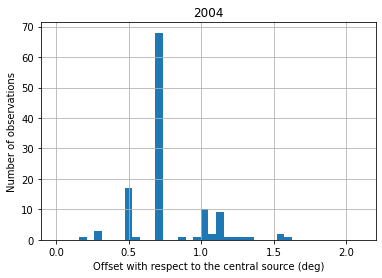

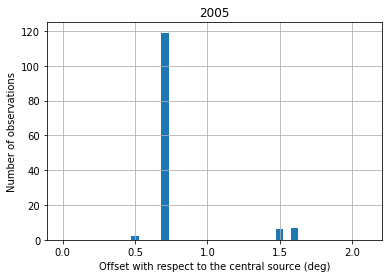

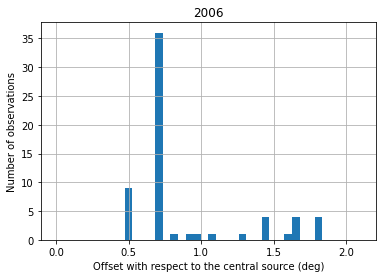

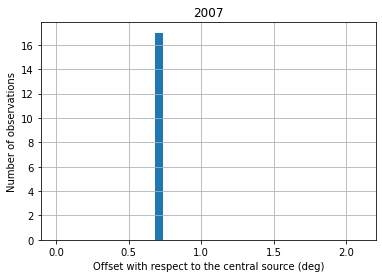

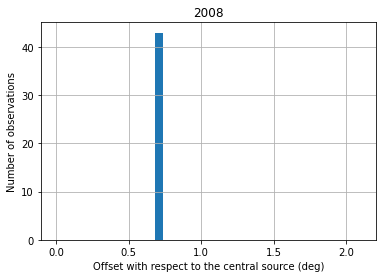

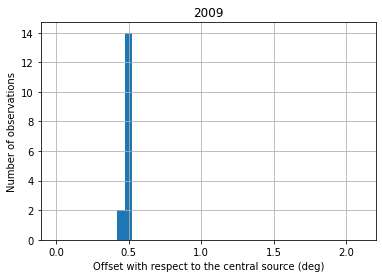

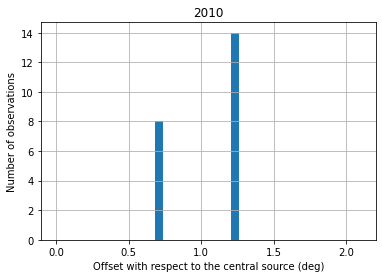

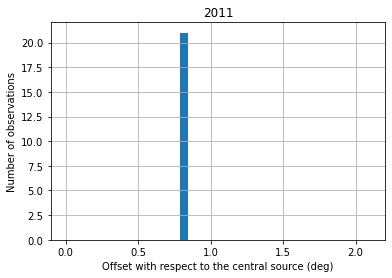

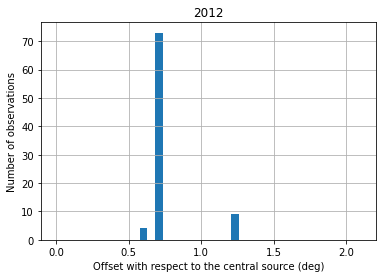

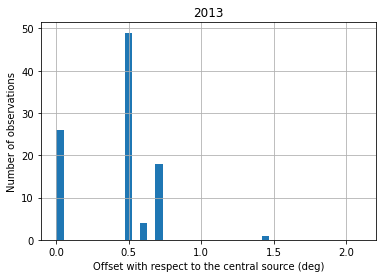

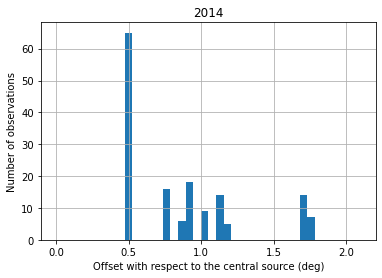

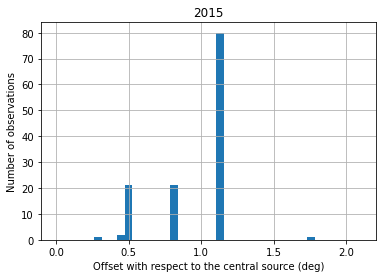

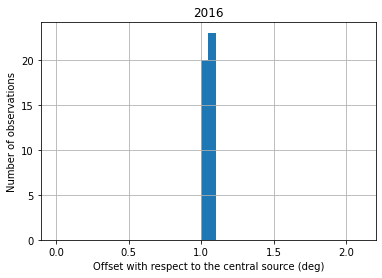

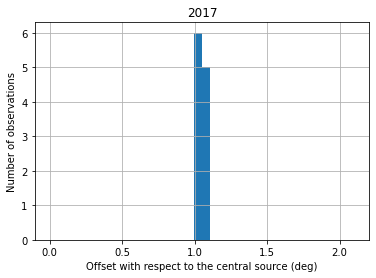

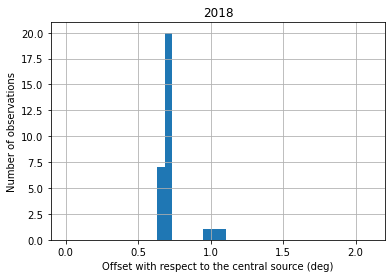

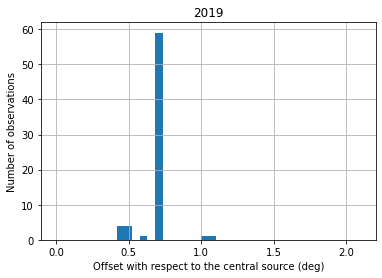

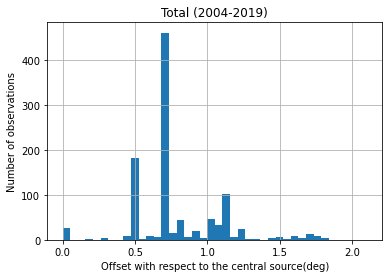

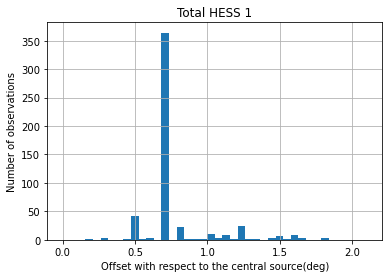

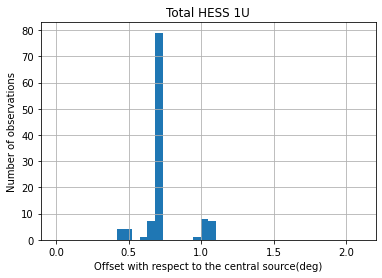

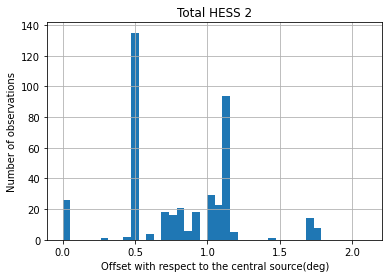

In [72]:
# Extracing offsets of observations (relative to SgrA*) for each year

sgra_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

histo_offset = dict()
offset_tot = []
offset_hess1 = []
offset_hess2 = []
offset_hess1u = []

for year in range(2004,2020):
    histo_offset[year] = []

for obs in observations1:
    year = obs.gti.time_start.jyear.astype('int')[0]
    
    direction = obs.pointing_radec
    sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
    
    histo_offset[year].append(sep.value)
    offset_tot.append(sep.value)
    offset_hess1.append(sep.value)
        
for obs in observations2:
    year = obs.gti.time_start.jyear.astype('int')[0]
    
    direction = obs.pointing_radec
    sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
    
    histo_offset[year].append(sep.value)
    offset_tot.append(sep.value)
    offset_hess2.append(sep.value)
    
for obs in observations1u:
    year = obs.gti.time_start.jyear.astype('int')[0]
    
    direction = obs.pointing_radec
    sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
    
    histo_offset[year].append(sep.value)
    offset_tot.append(sep.value)
    offset_hess1u.append(sep.value)
        
for year in range(2004,2020):        
    plt.figure()
    plt.hist(histo_offset[year], 40, (0.0, 2.1))
    
    plt.title(str(year))
    plt.grid()
    plt.xlabel("Offset with respect to the central source (deg)")
    plt.ylabel("Number of observations")
    
    name = "offsets_"+str(year)+"_hd.pdf"
    plt.savefig(patho/name, overwrite=True)
    

plt.figure()
plt.hist(offset_tot, 40, (0.0, 2.1))
    
plt.title("Total (2004-2019)")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_tot_hd.pdf'
plt.savefig(patho/name, overwrite=True)


plt.figure()
plt.hist(offset_hess1, 40, (0.0, 2.1))
    
plt.title("Total HESS 1")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_hess1_hd.pdf'
plt.savefig(patho/name, overwrite=True)


plt.figure()
plt.hist(offset_hess1u, 40, (0.0, 2.1))
    
plt.title("Total HESS 1U")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_hess1u_hd.pdf'
plt.savefig(patho/name, overwrite=True)



plt.figure()
plt.hist(offset_hess2, 40, (0.0, 2.1))
    
plt.title("Total HESS 2")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_hess2_hd.pdf'
plt.savefig(patho/name, overwrite=True)


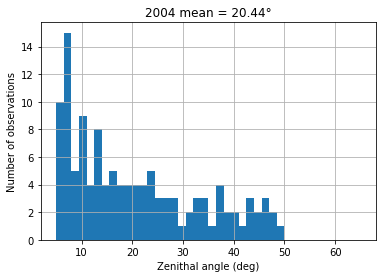

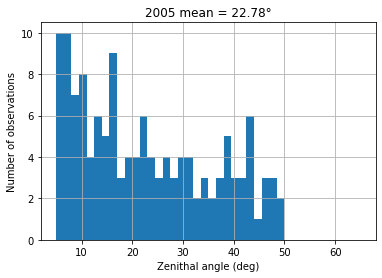

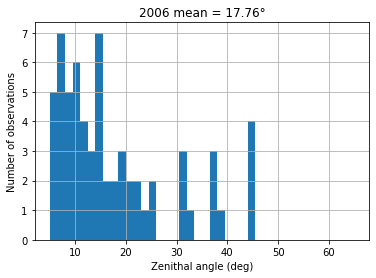

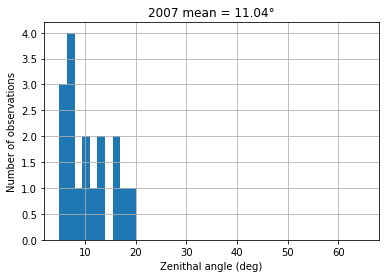

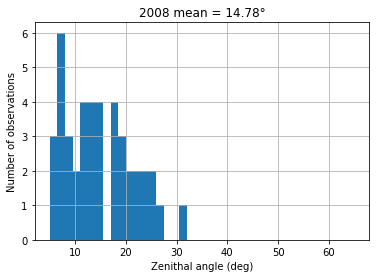

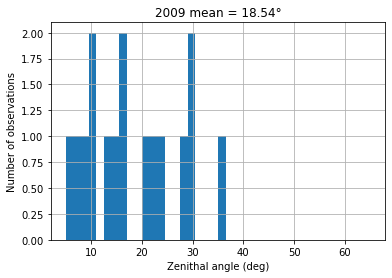

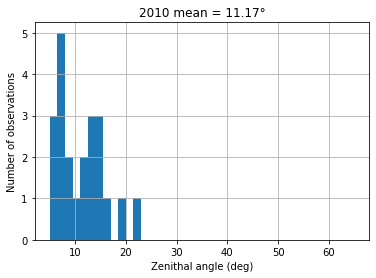

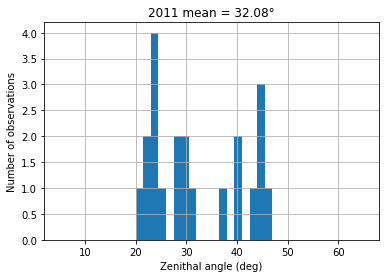

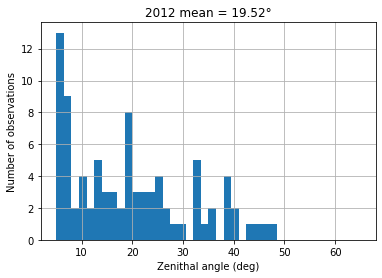

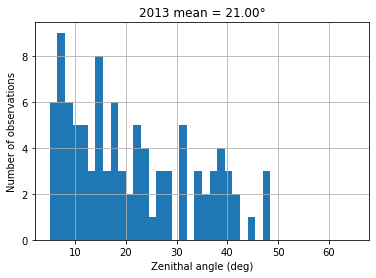

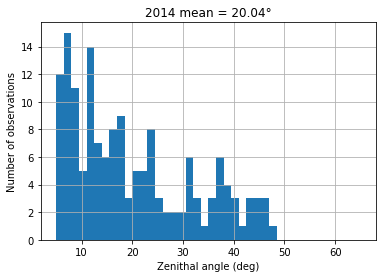

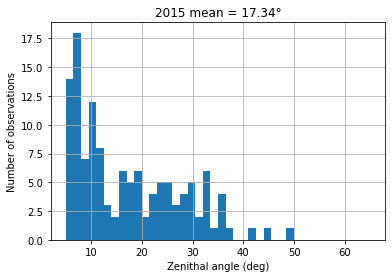

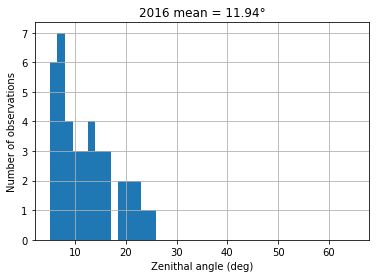

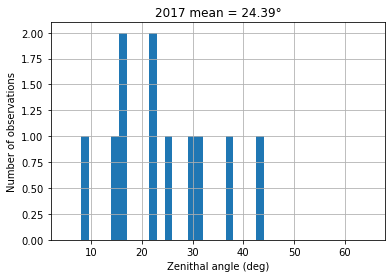

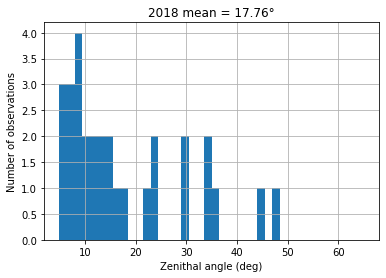

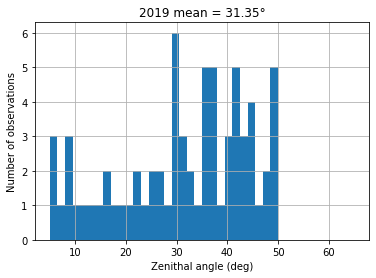

In [73]:
# Extracing zenithal angle of observation for each year

histo_zen = dict()
zen_tot = []

for year in range(2004,2020):  
    histo_zen[year] = []
    
    obs_table_year1 = obs_table1.select_observations(year_intervals[year])
    obs_table_year1u = obs_table1u.select_observations(year_intervals[year])
    obs_table_year2 = obs_table2.select_observations(year_intervals[year])
    
    res =  obs_table_year1["ZEN_PNT"].tolist() + obs_table_year1u["ZEN_PNT"].tolist() +obs_table_year2["ZEN_PNT"].tolist() 
    zen_tot += res
    
    histo_zen[year] = res
    
    plt.figure()
    plt.hist(histo_zen[year], 40, (5.0, 65.0))
    
    avg = np.mean(res)
    
    plt.title(str(year)+' mean = {0:0.2f}°'.format(avg))
    plt.grid()
    plt.xlabel("Zenithal angle (deg)")
    plt.ylabel("Number of observations")
    
    name = "angzen_"+str(year)+"_hd.pdf"
    plt.savefig(pathz/name, overwrite=True)

 

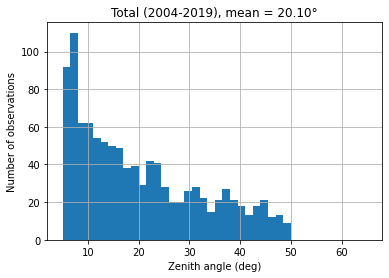

In [74]:
avg = np.mean(zen_tot)

plt.figure()
plt.hist(zen_tot, 40, (5.0, 65.0))
    
plt.title('Total (2004-2019), mean = {0:0.2f}°'.format(avg))
plt.grid()
plt.xlabel("Zenith angle (deg)")
plt.ylabel("Number of observations")

 
name = "angzen_tot_fr.pdf"
plt.savefig(pathz/name, overwrite=True) 

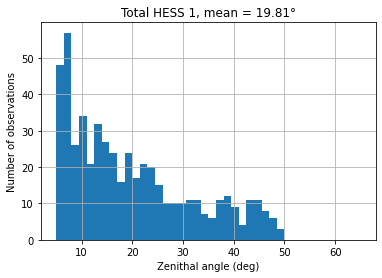

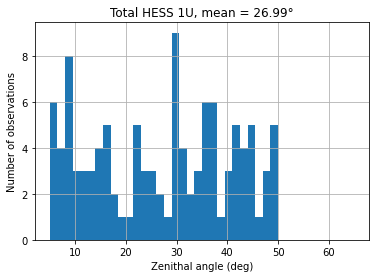

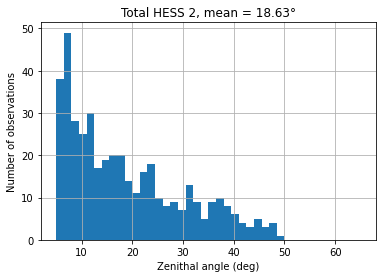

In [75]:
zen_hess1 = obs_table1["ZEN_PNT"].tolist()
avg = np.mean(zen_hess1)
plt.figure()
plt.hist(zen_hess1, 40, (5.0, 65.0))
    
plt.title('Total HESS 1, mean = {0:0.2f}°'.format(avg))
plt.grid()
plt.xlabel("Zenithal angle (deg)")
plt.ylabel("Number of observations")
    
name = "angzen_hess1_hd.pdf"
plt.savefig(pathz/name, overwrite=True)


zen_hess1u = obs_table1u["ZEN_PNT"].tolist()
avg = np.mean(zen_hess1u)
plt.figure()
plt.hist(zen_hess1u, 40, (5.0, 65.0))
    
plt.title('Total HESS 1U, mean = {0:0.2f}°'.format(avg))
plt.grid()
plt.xlabel("Zenithal angle (deg)")
plt.ylabel("Number of observations")
    
name = "angzen_hess1u_hd.pdf"
plt.savefig(pathz/name, overwrite=True)


zen_hess2 = obs_table2["ZEN_PNT"].tolist()
avg = np.mean(zen_hess2)
plt.figure()
plt.hist(zen_hess2, 40, (5.0, 65.0))
    
plt.title('Total HESS 2, mean = {0:0.2f}°'.format(avg))
plt.grid()
plt.xlabel("Zenithal angle (deg)")
plt.ylabel("Number of observations")
    
name = "angzen_hess2_hd.pdf"
plt.savefig(pathz/name, overwrite=True)

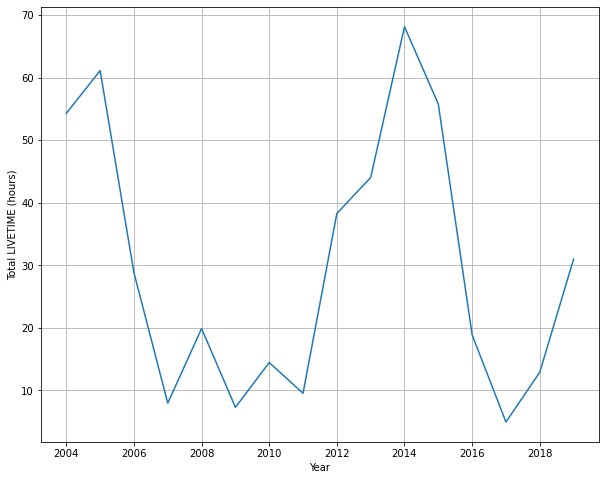

In [76]:
# Adding up LiveTime for each year

res = []
s1=0
s2=0
s1u =0

for year in range(2004,2020):
    obs_table_year1 = obs_table1.select_observations(year_intervals[year])
    obs_table_year1u = obs_table1u.select_observations(year_intervals[year])
    obs_table_year2 = obs_table2.select_observations(year_intervals[year])
    
    s1 +=sum(obs_table_year1["LIVETIME"].tolist())/3600
    s2 +=sum(obs_table_year2["LIVETIME"].tolist())/3600
    s1u +=sum(obs_table_year1u["LIVETIME"].tolist())/3600
    
    s = sum(obs_table_year1["LIVETIME"].tolist())/3600 +sum(obs_table_year1u["LIVETIME"].tolist())/3600 + sum(obs_table_year2["LIVETIME"].tolist())/3600
    res.append(s)


plt.figure(figsize=(10,8))

plt.plot(range(2004,2020), res)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Total LIVETIME (hours)")

name = "livetime_plot_hd_full.pdf"    
plt.savefig(path/name, overwrite=True)